<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/Mirabest_ensemble_lenet_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import shutil
import subprocess
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
nruns = 10
model = 'lenet'
image_size = 64

In [3]:
!nvidia-smi

Tue Sep  6 10:33:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [6]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 615, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 615 (delta 53), reused 15 (delta 6), pack-reused 531
Receiving objects: 100% (615/615), 1.13 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (434/434), done.


In [7]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl (189.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
for i, root in enumerate(glob.glob('/content/runs/*/')):
  shutil.rmtree(root, ignore_errors=True)

In [9]:
for i in range(nruns):
 base_cmd = ['python3', 'bnn_hmc/scripts/run_sgd.py', '--seed=%s' % i, '--weight_decay=10', '--dir=runs/sgd/mirabestc/%s/' % i, 
 '--dataset_name=mirabest/confident', '--model_name=%s' % model, '--init_step_size=3e-7', '--num_epochs=100', 
 '--eval_freq=5', '--batch_size=53', '--save_freq=5', '--optimizer=SGD', '--image_size=%s' % image_size]
 train_cmd = base_cmd + ['--train_split=train[:80%]', '--test_split=train[80%:]']
 eval_cmd = base_cmd + ['--eval_split=test']
 print(' '.join(train_cmd))
 p = subprocess.run(train_cmd, capture_output=True)
 print(p.stdout.decode('utf8'))
 p = subprocess.run(eval_cmd, capture_output=True)
 print(p.stdout.decode('utf8'))

python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/mirabestc/0/ --dataset_name=mirabest/confident --model_name=lenet --init_step_size=3e-7 --num_epochs=100 --eval_freq=5 --batch_size=53 --save_freq=5 --optimizer=SGD --image_size=64 --train_split=train[:80%] --test_split=train[80%:]
JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Starting from random initialization with provided seed
---  --------  ----------------  ---------------  ----------  -------------------  --------------  --------------  --------
  i         t    train/accuracy    test/accuracy    test/nll  test/ens_accuracy    test/ens_nll    test/ens_ece          lr
---  --------  ----------------  ---------------  ----------  -------------------  --------------  --------------  --------
  0    3.5866            0.6192           0.6438      0.6641                                       

In [10]:
base_cmd = ['python3', 'bnn_hmc/scripts/run_sgd.py', '--seed=%s' % 0, '--weight_decay=10', '--dir=runs/sgd/mirabestc/%s/' % 0, 
 '--dataset_name=mirabest/confident', '--model_name=%s' % model, '--init_step_size=3e-7', '--num_epochs=100', 
 '--eval_freq=5', '--batch_size=53', '--save_freq=5', '--optimizer=SGD', '--image_size=%s' % image_size]
eval_cmd = base_cmd + ['--eval_split=test', '--ensemble_root=/content/runs/sgd/mirabestc/*/*']
p = subprocess.run(eval_cmd, capture_output=True)
print(p.stdout.decode('utf8'))

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Continuing the run from the last saved checkpoint
{'accuracy': DeviceArray(0.9038462, dtype=float32), 'nll': 0.26677158, 'ece': 0.09496193952285328}



In [11]:
accuracies = []
nlls = []
eces = []
softmax = []
for i, root in enumerate(glob.glob('/content/runs/sgd/mirabestc/*/*/')):
  data = np.load(root + '/test_set.npy')  
  prediction = np.load(root + '/predictions.npy')
  softmax.append(np.squeeze(prediction))
softmax = np.array(softmax)

In [12]:
mean_softmax = np.mean(softmax, axis=0)
ensemble_accuracy = np.mean(np.argmax(mean_softmax, axis=-1) == data)
print('Ensemble accuracy', ensemble_accuracy)

Ensemble accuracy 0.9038461538461539


In [13]:
def uncertainty(softmax):
  # Per example softmax with shape(num_examples, num_classes)
  predictive_entropy = 0
  single_pass_entropy = 0
  for i in range(softmax.shape[1]):
    # Sum over classes
    predictive_entropy += -np.mean(softmax[:,i])*np.log(np.mean(softmax[:,i]))
    single_pass_entropy += -softmax[:,i]*np.log(softmax[:,i])
  single_pass_entropy = np.mean(single_pass_entropy)
  mutual_info = predictive_entropy - single_pass_entropy
  return predictive_entropy, single_pass_entropy, mutual_info

In [14]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

Predictive entropy: 0.40919739193318844 0.20746195731979183
Single pass entropy: 0.38243836 0.19357586
Mutual info: 0.026759028425798394 0.02059557475844634


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


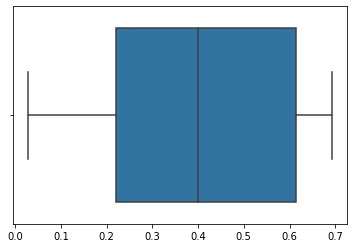

In [15]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


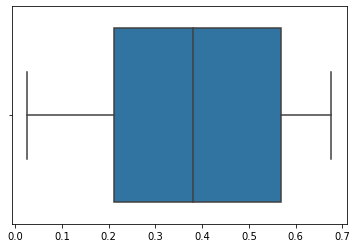

In [16]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


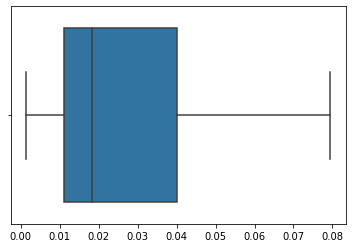

In [17]:
sns.boxplot(mutual_infos)
plt.show()